# Anomaly Detection in Network Data using GANs

Welcome to the third lab of this series!

In the previous labs, we tried our hand at supervised and unsupervised anomaly detection using XGBoost and Deep Autoencoders on the KDD-99 network intrusion dataset.

We addressed the issue of unlabelled training data through the use of Deep Autoencoders in the second lab. However, unsupervised methods such as PCA and Autoencoders tend to be effective only on highly correlated data such as the KDD dataset, and these algorithms might also require the data to follow a Gaussian Distribution.

> "Adversarial training (also called GAN for Generative Adversarial Networks), and the variations that are now being proposed, is the most interesting idea in the last 10 years in ML, in my opinion.".
> Yann LeCun, 2016.

What do GANs bring to the table and how are they different from Deep Autoencoders?

GANs are generative models that generate samples similar to the training dataset by learning the true data distribution. So instead of compressing the input into a latent space and classifying the test samples based on the reconstruction error, we actually train a classifier that outputs a probability score of a sample being Normal or Anomalous. As we will see later in the lab, this has positioned GANs as very attaractive unsupervised learning techniques.

GANs can be pretty tough to train and improving their stability is an active area of research today.

In [2]:
%pip install numpy pandas tqdm matplotlib scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Import system packages
import os
import sys
import time
import logging
import importlib

#Import data manipulation libraries
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm

#Import visualization libraries
import matplotlib.pyplot as plt

#Importing ML/DL libraries
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layer

from tensorflow.keras import initializers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Activation 
from tensorflow.keras.layers import Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate
import pickle

import random
random.seed(123)

data_path = 'data/'

## Section 1: Dataset

Let us load the same KDD-99 dataset that we used in the previous labs. 

In [3]:
#loading the pickled file

filename = data_path + 'preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

Just like in Lab 2, we will split the pickled data into vectors and assign them to the label encoder `le`, training and testing sets.

In [4]:
for key in preprocessed_data:
    print(key)  

x_train
y_train
x_test
y_test
le


In [5]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

In [6]:
np.unique(y_train)

array([ 0,  5,  9, 10, 11, 15, 17, 18, 20])

### 1.1 Data Preprocessing

We first consider the binary classification problem. Similar to previous labs, *Normal* data points will be labeled as '0' and *Anomalous* points will be labeled as '1'.

In [7]:
#Obtain the class number for Normal entries 
pd.DataFrame(le.classes_, columns = ['Type'])

,Type
0,back.
1,buffer_overflow.
2,ftp_write.
3,guess_passwd.
4,imap.
5,ipsweep.
6,land.
7,loadmodule.
8,multihop.
9,neptune.


In [8]:
# Converting labels to Binary

y_test[y_test != 11] = 1 
y_test[y_test == 11] = 0
y_train[y_train != 11] = 1
y_train[y_train == 11] = 0

We will now split the dataset into normal and anomalous data. We will need to do this in order to be able to train GANs to generate Normal packets only and then predict the anomaly based on the Discriminator output. The details regarding this will be covered later in the lab.

In [9]:
#Subsetting only Normal Network packets in our training set

temp_df = x_train.copy()
temp_df['label'] = y_train
temp_df = temp_df.loc[temp_df['label'] == 0]
temp_df = temp_df.drop('label', axis = 1)
x_train = temp_df.copy()

Similar to Lab 2, we scale the input training data between 0 and 1 before feeding it to the model.

In [10]:
# Normalize the above splits using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Creating dataset dictionary 
dataset = {}
dataset['x_train'] = x_train.astype(np.float32)
dataset['y_train'] = y_train.astype(np.float32)
dataset['x_test']  = x_test.astype(np.float32)
dataset['y_test']  = y_test.astype(np.float32)

**Summary of the datasets** :
- The Training set consists of only normal network packets.
- The Testing set comprises a small number of anomalous network packets of about 1%, reflecting what we see in the real world. 


In [11]:
# check how many anomalies are in our Testing set
print('Number of Normal Network packets in the Training set:', x_train.shape[0])
print('Number of Normal Network packets in the Testing set:', collections.Counter(y_test)[0])
print('Number of Anomalous Network packets in the Testing set:', collections.Counter(y_test)[1])

Number of Normal Network packets in the Training set: 729620
Number of Normal Network packets in the Testing set: 243161
Number of Anomalous Network packets in the Testing set: 2466


## Section 2: Generative Adversarial Networks

Generative Adversarial Networks (GAN) were introduced by Ian Goodfellow in [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661), Goodfellow, 2014.

<br>
<img src="https://drive.google.com/uc?id=14f7ZwXxyigpwx7bIVFxAOSb_aV28bFav" alt="Alt text that describes the graphic" title="Title text" />
<br>


The GAN consists of two networks namely: 
- The generator `G` that produces fake samples
- The discriminator `D` that that receives samples from both `G` and the dataset.

During Training the two networks have competing goals. The generator tries to fool the discriminator by outputting values that resemble real data and the discriminator tries to become better at distinguishing between the real and fake data.

Mathematically, this means that the Generator's weights are optimized to maximize the probability that fake data is classified as belonging to the real data. The discriminators's weights are optimized to maximize the probability that the real input data is classified as real while minimizing the probability of fake input data being classified as real.

Optimality is reached when the generator produces an output that the disciminator cannot concretely label as real or fake and this, happens when either of the networks cannot improve anymore.

<img src=./images/gan-optimality.PNG alt="Alt text that describes the graphic" title="Title text" />

The first part of the above equation reflects the log probability of the discriminator predicting that the input sample is genuine and the second half reflects the probability of the Discriminator predicting that the Generator's output is not genuine.

In this lab, we will be train our GAN on normal network packets. The generator inputs noise and as training progresses the GAN learns the mapping between these random values to the input distribution. The discriminator outputs a score of how likely the the generated output resembles the real data.

### 2.1 Generator Network 

The Generator is used to synthesize fake data points. As shown below, it consists of 5 Dense Layers with a `tanh` activation function and uses `binary cross-entropy` for calculating the generator loss. Binary cross-entropy loss measures the performance of a two class classification model whose output is a probability value between 0 and 1. A perfect model would have a loss of 0.

![layers](images/layers.png)

In [13]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()  # Enable eager execution here

# Now, import other libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import numpy as np
from tqdm import tqdm
import tensorflow as tf
print(tf.__version__)  # Check TensorFlow version
print("Eager Execution Enabled:", tf.executing_eagerly())  # Check if eager execution is enabled

2.18.0
Eager Execution Enabled: True


In [14]:
# Defining the Generator network

def get_generator(optimizer):
    
    generator = Sequential()
    generator.add(Dense(64, input_dim=116, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
       
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
   
    generator.add(Dense(116, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

### 2.2 Discriminator Network

![layers2](images/layers2.png)

The Discriminator basically outputs the score of a sample belonging to the real dataset or the synthetic dataset. It consists of 6 dense layers-each followed by a dropout layer to help prevent overfitting. The sigmoid activation function is applied to the final layer to obtain a value in the range 0 to 1.

In [15]:
##### Defining the Discriminator network

def get_discriminator(optimizer):
    
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=116, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

### 2.3 Building the Network

Previously we built the individual networks that constitute the GAN. Let us now stich them together by using the generator and discriminator as individual layers of the overall generative adversarial network. We set the field `discriminator.trainable = False` as we want to alter the weights of only one of them during training.

In [16]:
def get_gan_network(discriminator, generator, optimizer,input_dim=116):

    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

### 2.4 Setting the Hyperparameters 

Training a GAN can be quite tricky and time consuming. Refer to this <a href="https://github.com/soumith/ganhacks#authors">  link </a> to get a few ideas on how you could get your models to converge faster by choosing appropriate hyperparameters.

In [19]:
learning_rate = 0.00001
batch_size = 256
epochs = 15
adam = Adam(learning_rate = learning_rate,beta_1 = 0.01)

### 2.5 Training the Model

The generator first predicts on a batch of noise samples. As the generator has randomly initialized weights initially, the output of the generator at this stage is nothing but meaningless values.
<br>
<img src=./images/Gan-Page-04.jpg alt="Alt text that describes the graphic" title="Title text" />
<br>
The Discriminator inputs a stack of samples - the first half of which is the output of the generator and the second half is a batch of data samples from the real dataset. We train the Discriminator on this stack with the target labels  0 (Fake) for half the stack and 1 for the second half of the stack. The result of this is that the Discrimator is able to distinguish between the Real and Fake samples.
<br>
<img src=./images/Gan-Page-2.jpg alt="Alt text that describes the graphic" title="Title text" />
<br>
The weights of the discriminator are frozen by setting the trainable parameter to False.

To train the Generator, We first feed it random noise and let the entire GAN output a probability with the Discriminator weights remaining frozen. As expected this value would be less than 0.5 since the Discriminator was previously set to output a value close to 0 if the input was not genuine .
<br>
<img src=./images/Gan-Page-3.jpg alt="Alt text that describes the graphic" title="Title text" />
<br>

Now comes the trick. We tell the GAN that the expected output is 1. This results in the errors being backpropagated only to the Generator. With every sample in the batch the generator's weights are tuned such that the output of the GAN is close to 1, meaning the Generator is now learning to produce samples that resemble the real data.

This process loops back to the first step for each batch in the training set.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import numpy as np
from tqdm import tqdm

# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

# Defining the Generator network
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(64, input_dim=114, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(128))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(256))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(512))
    generator.add(Activation('tanh'))
    
    generator.add(Dense(114, activation='tanh'))  # Fix: Change output dimension to 114
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return generator

# Defining the Discriminator network
def get_discriminator(optimizer):
    discriminator = Sequential()
    
    discriminator.add(Dense(256, input_dim=114, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))
    
    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))
   
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator

# Defining the GAN network
def get_gan_network(discriminator, generator, optimizer, input_dim=114):
    discriminator.trainable = False   
    gan_input = Input(shape=(input_dim,))  
    x = generator(gan_input)        
    gan_output = discriminator(x)
    
    gan = Model(inputs=gan_input, outputs=gan_output)    
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return gan

learning_rate = 0.0001
batch_size = 8
epochs = 75
adam = Adam(learning_rate=learning_rate, beta_1=0.01)

# Example dataset placeholder (replace with actual dataset)
x_train, y_train, x_test, y_test = np.random.randn(1000, 114), np.random.randint(0, 2, size=1000), np.random.randn(100, 114), np.random.randint(0, 2, size=100)
print("x_train shape:", x_train.shape)

# Calculating the number of batches based on the batch size
batch_count = x_train.shape[0] // batch_size
pbar = tqdm(total=epochs * batch_count)
gan_loss = []
discriminator_loss = []

# Initializing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam, input_dim=114)

# Training the GAN
for epoch in range(epochs):        
    for index in range(batch_count):        
        pbar.update(1)        
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size, 114])
        
        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)
        
        # Obtain a batch of real images
        image_batch = x_train[index * batch_size: (index + 1) * batch_size]
            
        X = np.vstack((generated_images, image_batch))       
        y_dis = np.ones(2 * batch_size) 
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 114])
        y_gen = np.ones(batch_size)

        # Recreate optimizer for GAN to avoid reuse issues
        gan_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
        discriminator.trainable = False
        gan = get_gan_network(discriminator, generator, gan_optimizer, input_dim=114)  # Recompile with the new optimizer
        g_loss = gan.train_on_batch(noise, y_gen)
        
        # Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)
        
    print(f"Epoch {epoch}/{epochs} Batch {index}/{batch_count} [D loss: {d_loss}] [G loss: {g_loss}]")

x_train shape: (1000, 114)


 11%|█         | 198/1860 [00:54<07:34,  3.66it/s]


Epoch 0/50 Batch 249/250 [D loss: 0.6319502592086792] [G loss: 0.2788771986961365]


Epoch 1/50 Batch 249/250 [D loss: 0.6073512434959412] [G loss: 0.3298598527908325]


Epoch 2/50 Batch 249/250 [D loss: 0.5737424492835999] [G loss: 0.6687219142913818]


Epoch 3/50 Batch 249/250 [D loss: 0.5318328142166138] [G loss: 0.22722774744033813]


  8%|▊         | 1002/12500 [02:35<31:52,  6.01it/s]

Epoch 4/50 Batch 249/250 [D loss: 0.501980185508728] [G loss: 0.4526139199733734]


Epoch 5/50 Batch 249/250 [D loss: 0.48365679383277893] [G loss: 0.6401181221008301]


Epoch 6/50 Batch 249/250 [D loss: 0.4712800085544586] [G loss: 0.23273597657680511]


Epoch 7/50 Batch 249/250 [D loss: 0.460599809885025] [G loss: 0.6784167289733887]


Epoch 8/50 Batch 249/250 [D loss: 0.45222529768943787] [G loss: 0.4864414632320404]


Epoch 9/50 Batch 249/250 [D loss: 0.4450778365135193] [G loss: 1.5346624851226807]


Epoch 10/50 Batch 249/250 [D loss: 0.43998467922210693] [G loss: 1.1859104633331299]


Epoch 11/50 Batch 249/250 [D loss: 0.433558851480484] [G loss: 1.6458388566970825]


Epoch 12/50 Batch 249/250 [D loss: 0.429144948720932] [G loss: 0.6726438999176025]


Epoch 13/50 Batch 249/250 [D loss: 0.4252987205982208] [G loss: 1.4468598365783691]


 28%|██▊       | 3502/12500 [09:13<24:33,  6.10it/s]

Epoch 14/50 Batch 249/250 [D loss: 0.4187488257884979] [G loss: 1.1822631359100342]


Epoch 15/50 Batch 249/250 [D loss: 0.41628962755203247] [G loss: 1.6854320764541626]


Epoch 16/50 Batch 249/250 [D loss: 0.4124535322189331] [G loss: 1.0702987909317017]


Epoch 17/50 Batch 249/250 [D loss: 0.40959036350250244] [G loss: 0.6966562867164612]


Epoch 18/50 Batch 249/250 [D loss: 0.4074476361274719] [G loss: 1.05089271068573]


Epoch 19/50 Batch 249/250 [D loss: 0.4037800133228302] [G loss: 4.031329154968262]


Epoch 20/50 Batch 249/250 [D loss: 0.39893558621406555] [G loss: 1.6576706171035767]


Epoch 21/50 Batch 249/250 [D loss: 0.3957803547382355] [G loss: 2.4482173919677734]


Epoch 22/50 Batch 249/250 [D loss: 0.3930895924568176] [G loss: 0.9892897009849548]


Epoch 23/50 Batch 249/250 [D loss: 0.3878367245197296] [G loss: 1.1918116807937622]


Epoch 24/50 Batch 249/250 [D loss: 0.385723739862442] [G loss: 1.6703197956085205]


Epoch 25/50 Batch 249/250 [D loss: 0.3814478814601898] [G loss: 3.2698495388031006]


Epoch 26/50 Batch 249/250 [D loss: 0.3776894509792328] [G loss: 0.781934916973114]


Epoch 27/50 Batch 249/250 [D loss: 0.375216543674469] [G loss: 0.8331930041313171]


Epoch 28/50 Batch 249/250 [D loss: 0.3737286925315857] [G loss: 2.0235755443573]


Epoch 29/50 Batch 249/250 [D loss: 0.3732287287712097] [G loss: 0.8445890545845032]


Epoch 30/50 Batch 249/250 [D loss: 0.3716140687465668] [G loss: 1.3259321451187134]


Epoch 31/50 Batch 249/250 [D loss: 0.37004563212394714] [G loss: 1.5124703645706177]


Epoch 32/50 Batch 249/250 [D loss: 0.3681245446205139] [G loss: 2.4545602798461914]


Epoch 33/50 Batch 249/250 [D loss: 0.36562681198120117] [G loss: 2.0264103412628174]


Epoch 34/50 Batch 249/250 [D loss: 0.36297178268432617] [G loss: 1.870532751083374]


Epoch 35/50 Batch 249/250 [D loss: 0.360299289226532] [G loss: 1.9852397441864014]


Epoch 36/50 Batch 249/250 [D loss: 0.35790854692459106] [G loss: 1.1595566272735596]


Epoch 37/50 Batch 249/250 [D loss: 0.3560657501220703] [G loss: 1.8520307540893555]


Epoch 38/50 Batch 249/250 [D loss: 0.3536303639411926] [G loss: 2.75471830368042]


Epoch 39/50 Batch 249/250 [D loss: 0.35003504157066345] [G loss: 3.1400885581970215]


Epoch 40/50 Batch 249/250 [D loss: 0.34782448410987854] [G loss: 3.4631786346435547]


Epoch 41/50 Batch 249/250 [D loss: 0.34553101658821106] [G loss: 3.892268180847168]


Epoch 42/50 Batch 249/250 [D loss: 0.3433547914028168] [G loss: 2.068713903427124]


Epoch 43/50 Batch 249/250 [D loss: 0.3415156900882721] [G loss: 3.1881327629089355]


Epoch 44/50 Batch 249/250 [D loss: 0.33963078260421753] [G loss: 2.1356663703918457]


Epoch 45/50 Batch 249/250 [D loss: 0.33730119466781616] [G loss: 1.6390459537506104]


 92%|█████████▏| 11502/12500 [31:55<02:57,  5.62it/s]

Epoch 46/50 Batch 249/250 [D loss: 0.3348654508590698] [G loss: 2.801997184753418]


Epoch 47/50 Batch 249/250 [D loss: 0.3331490159034729] [G loss: 1.604873538017273]


Epoch 48/50 Batch 249/250 [D loss: 0.33135199546813965] [G loss: 1.940345048904419]


Epoch 49/50 Batch 249/250 [D loss: 0.33015692234039307] [G loss: 2.4859421253204346]


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
import numpy as np
from tqdm import tqdm

# Ensure eager execution
tf.config.run_functions_eagerly(True)

# Define Generator
def get_generator():
    generator = Sequential([
        Dense(64, input_dim=116, kernel_initializer=initializers.glorot_normal(seed=42)),
        Activation('tanh'),
        Dense(128, activation='tanh'),
        Dense(256, activation='tanh'),
        Dense(256, activation='tanh'),
        Dense(512, activation='tanh'),
        Dense(116, activation='tanh')  # Matching the output dimension to 116
    ])
    return generator

# Define Discriminator
def get_discriminator():
    discriminator = Sequential([
        Dense(256, input_dim=116, kernel_initializer=initializers.glorot_normal(seed=42)),
        Activation('relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return discriminator

# Define GAN
def get_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(116,))
    generated_output = generator(gan_input)
    gan_output = discriminator(generated_output)
    return Model(inputs=gan_input, outputs=gan_output)

# Hyperparameters
learning_rate = 0.00001
batch_size = 512
epochs = 100

# Create separate optimizers
gen_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)
disc_optimizer = Adam(learning_rate=learning_rate, beta_1=0.5)

# Initialize models
generator = get_generator()
discriminator = get_discriminator()
gan = get_gan(generator, discriminator)

# Compile with separate optimizers
generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

# Example dataset (Replace with actual data)
x_train = np.random.randn(10000, 116)  # Increased dataset size
print("x_train shape:", x_train.shape)

# Number of batches
batch_count = x_train.shape[0] // batch_size

# Training loop
for epoch in range(epochs):
    with tqdm(total=batch_count, desc=f"Epoch {epoch}/{epochs}", unit="batch") as pbar:
        for index in range(batch_count):
            # Generate random noise
            noise = np.random.normal(0, 1, (batch_size, 116))
            fake_data = generator.predict_on_batch(noise)

            # Get real data batch
            real_data = x_train[index * batch_size: (index + 1) * batch_size]

            # Combine real and fake data
            X = np.vstack((fake_data, real_data))
            y_dis = np.ones(2 * batch_size)
            y_dis[:batch_size] = 0  # Label fake as 0

            # Train Discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)

            # Train Generator
            noise = np.random.normal(0, 1, (batch_size, 116))
            y_gen = np.ones(batch_size)  # Labels for fake samples as real (1)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y_gen)

            # Update progress bar
            pbar.set_postfix(D_loss=f"{d_loss:.6f}", G_loss=f"{g_loss:.6f}")
            pbar.update(1)

    # Print epoch summary
    print(f"Epoch {epoch}/{epochs} Batch {batch_count}/{batch_count} [D loss: {d_loss:.6f}] [G loss: {g_loss:.6f}]")


x_train shape: (10000, 116)


Epoch 0/100: 100%|██████████| 19/19 [00:04<00:00,  3.90batch/s, D_loss=0.818075, G_loss=0.769995]


Epoch 0/100 Batch 19/19 [D loss: 0.818075] [G loss: 0.769995]


Epoch 1/100: 100%|██████████| 19/19 [00:04<00:00,  4.08batch/s, D_loss=0.808615, G_loss=0.760047]


Epoch 1/100 Batch 19/19 [D loss: 0.808615] [G loss: 0.760047]


Epoch 2/100: 100%|██████████| 19/19 [00:04<00:00,  4.00batch/s, D_loss=0.798674, G_loss=0.751405]


Epoch 2/100 Batch 19/19 [D loss: 0.798674] [G loss: 0.751405]


Epoch 3/100: 100%|██████████| 19/19 [00:04<00:00,  3.95batch/s, D_loss=0.789326, G_loss=0.743198]


Epoch 3/100 Batch 19/19 [D loss: 0.789326] [G loss: 0.743198]


Epoch 4/100: 100%|██████████| 19/19 [00:04<00:00,  3.87batch/s, D_loss=0.780109, G_loss=0.735540]


Epoch 4/100 Batch 19/19 [D loss: 0.780109] [G loss: 0.735540]


Epoch 5/100: 100%|██████████| 19/19 [00:04<00:00,  3.96batch/s, D_loss=0.771703, G_loss=0.728235]


Epoch 5/100 Batch 19/19 [D loss: 0.771703] [G loss: 0.728235]


Epoch 6/100: 100%|██████████| 19/19 [00:04<00:00,  3.97batch/s, D_loss=0.763731, G_loss=0.721399]


Epoch 6/100 Batch 19/19 [D loss: 0.763731] [G loss: 0.721399]


Epoch 7/100: 100%|██████████| 19/19 [00:04<00:00,  3.97batch/s, D_loss=0.755983, G_loss=0.714984]


Epoch 7/100 Batch 19/19 [D loss: 0.755983] [G loss: 0.714984]


Epoch 8/100: 100%|██████████| 19/19 [00:04<00:00,  4.00batch/s, D_loss=0.749160, G_loss=0.708627]


Epoch 8/100 Batch 19/19 [D loss: 0.749160] [G loss: 0.708627]


Epoch 9/100: 100%|██████████| 19/19 [00:04<00:00,  4.19batch/s, D_loss=0.742560, G_loss=0.702332]


Epoch 9/100 Batch 19/19 [D loss: 0.742560] [G loss: 0.702332]


Epoch 10/100: 100%|██████████| 19/19 [00:04<00:00,  4.01batch/s, D_loss=0.736319, G_loss=0.696119]


Epoch 10/100 Batch 19/19 [D loss: 0.736319] [G loss: 0.696119]


Epoch 11/100: 100%|██████████| 19/19 [00:04<00:00,  4.19batch/s, D_loss=0.730664, G_loss=0.689865]


Epoch 11/100 Batch 19/19 [D loss: 0.730664] [G loss: 0.689865]


Epoch 12/100: 100%|██████████| 19/19 [00:04<00:00,  4.23batch/s, D_loss=0.725582, G_loss=0.683398]


Epoch 12/100 Batch 19/19 [D loss: 0.725582] [G loss: 0.683398]


Epoch 13/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.721103, G_loss=0.677010]


Epoch 13/100 Batch 19/19 [D loss: 0.721103] [G loss: 0.677010]


Epoch 14/100: 100%|██████████| 19/19 [00:04<00:00,  4.16batch/s, D_loss=0.717066, G_loss=0.670496]


Epoch 14/100 Batch 19/19 [D loss: 0.717066] [G loss: 0.670496]


Epoch 15/100: 100%|██████████| 19/19 [00:04<00:00,  4.20batch/s, D_loss=0.713671, G_loss=0.663896]


Epoch 15/100 Batch 19/19 [D loss: 0.713671] [G loss: 0.663896]


Epoch 16/100: 100%|██████████| 19/19 [00:04<00:00,  4.29batch/s, D_loss=0.710744, G_loss=0.657390]


Epoch 16/100 Batch 19/19 [D loss: 0.710744] [G loss: 0.657390]


Epoch 17/100: 100%|██████████| 19/19 [00:04<00:00,  4.15batch/s, D_loss=0.708324, G_loss=0.650994]


Epoch 17/100 Batch 19/19 [D loss: 0.708324] [G loss: 0.650994]


Epoch 18/100: 100%|██████████| 19/19 [00:04<00:00,  4.18batch/s, D_loss=0.706235, G_loss=0.644911]


Epoch 18/100 Batch 19/19 [D loss: 0.706235] [G loss: 0.644911]


Epoch 19/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.704565, G_loss=0.639177]


Epoch 19/100 Batch 19/19 [D loss: 0.704565] [G loss: 0.639177]


Epoch 20/100: 100%|██████████| 19/19 [00:04<00:00,  4.22batch/s, D_loss=0.703107, G_loss=0.633849]


Epoch 20/100 Batch 19/19 [D loss: 0.703107] [G loss: 0.633849]


Epoch 21/100: 100%|██████████| 19/19 [00:04<00:00,  4.29batch/s, D_loss=0.701945, G_loss=0.628900]


Epoch 21/100 Batch 19/19 [D loss: 0.701945] [G loss: 0.628900]


Epoch 22/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.700761, G_loss=0.624420]


Epoch 22/100 Batch 19/19 [D loss: 0.700761] [G loss: 0.624420]


Epoch 23/100: 100%|██████████| 19/19 [00:04<00:00,  4.22batch/s, D_loss=0.699679, G_loss=0.620368]


Epoch 23/100 Batch 19/19 [D loss: 0.699679] [G loss: 0.620368]


Epoch 24/100: 100%|██████████| 19/19 [00:04<00:00,  4.24batch/s, D_loss=0.698729, G_loss=0.616701]


Epoch 24/100 Batch 19/19 [D loss: 0.698729] [G loss: 0.616701]


Epoch 25/100: 100%|██████████| 19/19 [00:04<00:00,  4.17batch/s, D_loss=0.697708, G_loss=0.613520]


Epoch 25/100 Batch 19/19 [D loss: 0.697708] [G loss: 0.613520]


Epoch 26/100: 100%|██████████| 19/19 [00:04<00:00,  4.21batch/s, D_loss=0.696690, G_loss=0.610698]


Epoch 26/100 Batch 19/19 [D loss: 0.696690] [G loss: 0.610698]


Epoch 27/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.695728, G_loss=0.608211]


Epoch 27/100 Batch 19/19 [D loss: 0.695728] [G loss: 0.608211]


Epoch 28/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.694761, G_loss=0.606015]


Epoch 28/100 Batch 19/19 [D loss: 0.694761] [G loss: 0.606015]


Epoch 29/100: 100%|██████████| 19/19 [00:04<00:00,  4.22batch/s, D_loss=0.693823, G_loss=0.604102]


Epoch 29/100 Batch 19/19 [D loss: 0.693823] [G loss: 0.604102]


Epoch 30/100: 100%|██████████| 19/19 [00:04<00:00,  4.28batch/s, D_loss=0.692945, G_loss=0.602401]


Epoch 30/100 Batch 19/19 [D loss: 0.692945] [G loss: 0.602401]


Epoch 31/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.692125, G_loss=0.600948]


Epoch 31/100 Batch 19/19 [D loss: 0.692125] [G loss: 0.600948]


Epoch 32/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.691316, G_loss=0.599657]


Epoch 32/100 Batch 19/19 [D loss: 0.691316] [G loss: 0.599657]


Epoch 33/100: 100%|██████████| 19/19 [00:04<00:00,  4.25batch/s, D_loss=0.690554, G_loss=0.598485]


Epoch 33/100 Batch 19/19 [D loss: 0.690554] [G loss: 0.598485]


Epoch 34/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.689875, G_loss=0.597406]


Epoch 34/100 Batch 19/19 [D loss: 0.689875] [G loss: 0.597406]


Epoch 35/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.689196, G_loss=0.596480]


Epoch 35/100 Batch 19/19 [D loss: 0.689196] [G loss: 0.596480]


Epoch 36/100: 100%|██████████| 19/19 [00:04<00:00,  4.28batch/s, D_loss=0.688476, G_loss=0.595657]


Epoch 36/100 Batch 19/19 [D loss: 0.688476] [G loss: 0.595657]


Epoch 37/100: 100%|██████████| 19/19 [00:04<00:00,  4.21batch/s, D_loss=0.687853, G_loss=0.594898]


Epoch 37/100 Batch 19/19 [D loss: 0.687853] [G loss: 0.594898]


Epoch 38/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.687240, G_loss=0.594294]


Epoch 38/100 Batch 19/19 [D loss: 0.687240] [G loss: 0.594294]


Epoch 39/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.686658, G_loss=0.593750]


Epoch 39/100 Batch 19/19 [D loss: 0.686658] [G loss: 0.593750]


Epoch 40/100: 100%|██████████| 19/19 [00:04<00:00,  4.21batch/s, D_loss=0.686061, G_loss=0.593327]


Epoch 40/100 Batch 19/19 [D loss: 0.686061] [G loss: 0.593327]


Epoch 41/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.685470, G_loss=0.592959]


Epoch 41/100 Batch 19/19 [D loss: 0.685470] [G loss: 0.592959]


Epoch 42/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.684863, G_loss=0.592667]


Epoch 42/100 Batch 19/19 [D loss: 0.684863] [G loss: 0.592667]


Epoch 43/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.684321, G_loss=0.592423]


Epoch 43/100 Batch 19/19 [D loss: 0.684321] [G loss: 0.592423]


Epoch 44/100: 100%|██████████| 19/19 [00:04<00:00,  4.21batch/s, D_loss=0.683759, G_loss=0.592193]


Epoch 44/100 Batch 19/19 [D loss: 0.683759] [G loss: 0.592193]


Epoch 45/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.683243, G_loss=0.592029]


Epoch 45/100 Batch 19/19 [D loss: 0.683243] [G loss: 0.592029]


Epoch 46/100: 100%|██████████| 19/19 [00:04<00:00,  4.28batch/s, D_loss=0.682674, G_loss=0.591889]


Epoch 46/100 Batch 19/19 [D loss: 0.682674] [G loss: 0.591889]


Epoch 47/100: 100%|██████████| 19/19 [00:04<00:00,  4.29batch/s, D_loss=0.682140, G_loss=0.591805]


Epoch 47/100 Batch 19/19 [D loss: 0.682140] [G loss: 0.591805]


Epoch 48/100: 100%|██████████| 19/19 [00:04<00:00,  4.28batch/s, D_loss=0.681639, G_loss=0.591727]


Epoch 48/100 Batch 19/19 [D loss: 0.681639] [G loss: 0.591727]


Epoch 49/100: 100%|██████████| 19/19 [00:04<00:00,  4.29batch/s, D_loss=0.681149, G_loss=0.591744]


Epoch 49/100 Batch 19/19 [D loss: 0.681149] [G loss: 0.591744]


Epoch 50/100: 100%|██████████| 19/19 [00:04<00:00,  4.19batch/s, D_loss=0.680676, G_loss=0.591756]


Epoch 50/100 Batch 19/19 [D loss: 0.680676] [G loss: 0.591756]


Epoch 51/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.680154, G_loss=0.591742]


Epoch 51/100 Batch 19/19 [D loss: 0.680154] [G loss: 0.591742]


Epoch 52/100: 100%|██████████| 19/19 [00:04<00:00,  4.23batch/s, D_loss=0.679685, G_loss=0.591777]


Epoch 52/100 Batch 19/19 [D loss: 0.679685] [G loss: 0.591777]


Epoch 53/100: 100%|██████████| 19/19 [00:04<00:00,  4.02batch/s, D_loss=0.679262, G_loss=0.591814]


Epoch 53/100 Batch 19/19 [D loss: 0.679262] [G loss: 0.591814]


Epoch 54/100: 100%|██████████| 19/19 [00:04<00:00,  4.28batch/s, D_loss=0.678842, G_loss=0.591818]


Epoch 54/100 Batch 19/19 [D loss: 0.678842] [G loss: 0.591818]


Epoch 55/100: 100%|██████████| 19/19 [00:04<00:00,  4.31batch/s, D_loss=0.678426, G_loss=0.591858]


Epoch 55/100 Batch 19/19 [D loss: 0.678426] [G loss: 0.591858]


Epoch 56/100: 100%|██████████| 19/19 [00:04<00:00,  4.21batch/s, D_loss=0.678061, G_loss=0.591880]


Epoch 56/100 Batch 19/19 [D loss: 0.678061] [G loss: 0.591880]


Epoch 57/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.677726, G_loss=0.591898]


Epoch 57/100 Batch 19/19 [D loss: 0.677726] [G loss: 0.591898]


Epoch 58/100: 100%|██████████| 19/19 [00:04<00:00,  4.24batch/s, D_loss=0.677431, G_loss=0.591908]


Epoch 58/100 Batch 19/19 [D loss: 0.677431] [G loss: 0.591908]


Epoch 59/100: 100%|██████████| 19/19 [00:04<00:00,  4.16batch/s, D_loss=0.677165, G_loss=0.591914]


Epoch 59/100 Batch 19/19 [D loss: 0.677165] [G loss: 0.591914]


Epoch 60/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.676943, G_loss=0.591929]


Epoch 60/100 Batch 19/19 [D loss: 0.676943] [G loss: 0.591929]


Epoch 61/100: 100%|██████████| 19/19 [00:04<00:00,  4.21batch/s, D_loss=0.676711, G_loss=0.591973]


Epoch 61/100 Batch 19/19 [D loss: 0.676711] [G loss: 0.591973]


Epoch 62/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.676525, G_loss=0.592093]


Epoch 62/100 Batch 19/19 [D loss: 0.676525] [G loss: 0.592093]


Epoch 63/100: 100%|██████████| 19/19 [00:04<00:00,  4.27batch/s, D_loss=0.676312, G_loss=0.592181]


Epoch 63/100 Batch 19/19 [D loss: 0.676312] [G loss: 0.592181]


Epoch 64/100: 100%|██████████| 19/19 [00:04<00:00,  4.25batch/s, D_loss=0.676103, G_loss=0.592294]


Epoch 64/100 Batch 19/19 [D loss: 0.676103] [G loss: 0.592294]


Epoch 65/100: 100%|██████████| 19/19 [00:04<00:00,  4.24batch/s, D_loss=0.675924, G_loss=0.592437]


Epoch 65/100 Batch 19/19 [D loss: 0.675924] [G loss: 0.592437]


Epoch 66/100: 100%|██████████| 19/19 [00:05<00:00,  3.62batch/s, D_loss=0.675723, G_loss=0.592598]


Epoch 66/100 Batch 19/19 [D loss: 0.675723] [G loss: 0.592598]


Epoch 67/100: 100%|██████████| 19/19 [00:04<00:00,  3.96batch/s, D_loss=0.675543, G_loss=0.592786]


Epoch 67/100 Batch 19/19 [D loss: 0.675543] [G loss: 0.592786]


Epoch 68/100: 100%|██████████| 19/19 [00:04<00:00,  4.33batch/s, D_loss=0.675350, G_loss=0.592996]


Epoch 68/100 Batch 19/19 [D loss: 0.675350] [G loss: 0.592996]


Epoch 69/100: 100%|██████████| 19/19 [00:04<00:00,  4.31batch/s, D_loss=0.675159, G_loss=0.593215]


Epoch 69/100 Batch 19/19 [D loss: 0.675159] [G loss: 0.593215]


Epoch 70/100: 100%|██████████| 19/19 [00:04<00:00,  4.35batch/s, D_loss=0.674973, G_loss=0.593483]


Epoch 70/100 Batch 19/19 [D loss: 0.674973] [G loss: 0.593483]


Epoch 71/100: 100%|██████████| 19/19 [00:04<00:00,  4.30batch/s, D_loss=0.674798, G_loss=0.593739]


Epoch 71/100 Batch 19/19 [D loss: 0.674798] [G loss: 0.593739]


Epoch 72/100: 100%|██████████| 19/19 [00:04<00:00,  4.32batch/s, D_loss=0.674626, G_loss=0.593992]


Epoch 72/100 Batch 19/19 [D loss: 0.674626] [G loss: 0.593992]


Epoch 73/100: 100%|██████████| 19/19 [00:04<00:00,  4.37batch/s, D_loss=0.674456, G_loss=0.594300]


Epoch 73/100 Batch 19/19 [D loss: 0.674456] [G loss: 0.594300]


Epoch 74/100: 100%|██████████| 19/19 [00:04<00:00,  4.37batch/s, D_loss=0.674295, G_loss=0.594627]


Epoch 74/100 Batch 19/19 [D loss: 0.674295] [G loss: 0.594627]


Epoch 75/100: 100%|██████████| 19/19 [00:04<00:00,  4.32batch/s, D_loss=0.674129, G_loss=0.594938]


Epoch 75/100 Batch 19/19 [D loss: 0.674129] [G loss: 0.594938]


Epoch 76/100: 100%|██████████| 19/19 [00:04<00:00,  4.38batch/s, D_loss=0.673970, G_loss=0.595251]


Epoch 76/100 Batch 19/19 [D loss: 0.673970] [G loss: 0.595251]


Epoch 77/100: 100%|██████████| 19/19 [00:04<00:00,  4.22batch/s, D_loss=0.673768, G_loss=0.595542]


Epoch 77/100 Batch 19/19 [D loss: 0.673768] [G loss: 0.595542]


Epoch 78/100: 100%|██████████| 19/19 [00:04<00:00,  4.30batch/s, D_loss=0.673579, G_loss=0.595837]


Epoch 78/100 Batch 19/19 [D loss: 0.673579] [G loss: 0.595837]


Epoch 79/100: 100%|██████████| 19/19 [00:04<00:00,  4.38batch/s, D_loss=0.673382, G_loss=0.596151]


Epoch 79/100 Batch 19/19 [D loss: 0.673382] [G loss: 0.596151]


Epoch 80/100: 100%|██████████| 19/19 [00:04<00:00,  4.30batch/s, D_loss=0.673163, G_loss=0.596480]


Epoch 80/100 Batch 19/19 [D loss: 0.673163] [G loss: 0.596480]


Epoch 81/100: 100%|██████████| 19/19 [00:04<00:00,  4.39batch/s, D_loss=0.672951, G_loss=0.596837]


Epoch 81/100 Batch 19/19 [D loss: 0.672951] [G loss: 0.596837]


Epoch 82/100: 100%|██████████| 19/19 [00:04<00:00,  4.31batch/s, D_loss=0.672716, G_loss=0.597190]


Epoch 82/100 Batch 19/19 [D loss: 0.672716] [G loss: 0.597190]


Epoch 83/100: 100%|██████████| 19/19 [00:04<00:00,  4.31batch/s, D_loss=0.672457, G_loss=0.597552]


Epoch 83/100 Batch 19/19 [D loss: 0.672457] [G loss: 0.597552]


Epoch 84/100: 100%|██████████| 19/19 [00:04<00:00,  4.30batch/s, D_loss=0.672190, G_loss=0.597896]


Epoch 84/100 Batch 19/19 [D loss: 0.672190] [G loss: 0.597896]


Epoch 85/100: 100%|██████████| 19/19 [00:06<00:00,  3.14batch/s, D_loss=0.671912, G_loss=0.598297]


Epoch 85/100 Batch 19/19 [D loss: 0.671912] [G loss: 0.598297]


Epoch 86/100: 100%|██████████| 19/19 [00:05<00:00,  3.26batch/s, D_loss=0.671618, G_loss=0.598671]


Epoch 86/100 Batch 19/19 [D loss: 0.671618] [G loss: 0.598671]


Epoch 87/100: 100%|██████████| 19/19 [00:04<00:00,  4.12batch/s, D_loss=0.671306, G_loss=0.599087]


Epoch 87/100 Batch 19/19 [D loss: 0.671306] [G loss: 0.599087]


Epoch 88/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.670971, G_loss=0.599506]


Epoch 88/100 Batch 19/19 [D loss: 0.670971] [G loss: 0.599506]


Epoch 89/100: 100%|██████████| 19/19 [00:04<00:00,  4.34batch/s, D_loss=0.670632, G_loss=0.599961]


Epoch 89/100 Batch 19/19 [D loss: 0.670632] [G loss: 0.599961]


Epoch 90/100: 100%|██████████| 19/19 [00:04<00:00,  4.38batch/s, D_loss=0.670280, G_loss=0.600380]


Epoch 90/100 Batch 19/19 [D loss: 0.670280] [G loss: 0.600380]


Epoch 91/100: 100%|██████████| 19/19 [00:04<00:00,  4.34batch/s, D_loss=0.669896, G_loss=0.600808]


Epoch 91/100 Batch 19/19 [D loss: 0.669896] [G loss: 0.600808]


Epoch 92/100: 100%|██████████| 19/19 [00:04<00:00,  4.34batch/s, D_loss=0.669517, G_loss=0.601244]


Epoch 92/100 Batch 19/19 [D loss: 0.669517] [G loss: 0.601244]


Epoch 93/100: 100%|██████████| 19/19 [00:04<00:00,  4.26batch/s, D_loss=0.669130, G_loss=0.601688]


Epoch 93/100 Batch 19/19 [D loss: 0.669130] [G loss: 0.601688]


Epoch 94/100: 100%|██████████| 19/19 [00:04<00:00,  4.28batch/s, D_loss=0.668750, G_loss=0.602131]


Epoch 94/100 Batch 19/19 [D loss: 0.668750] [G loss: 0.602131]


Epoch 95/100: 100%|██████████| 19/19 [00:04<00:00,  4.41batch/s, D_loss=0.668376, G_loss=0.602567]


Epoch 95/100 Batch 19/19 [D loss: 0.668376] [G loss: 0.602567]


Epoch 96/100: 100%|██████████| 19/19 [00:04<00:00,  4.33batch/s, D_loss=0.668037, G_loss=0.602985]


Epoch 96/100 Batch 19/19 [D loss: 0.668037] [G loss: 0.602985]


Epoch 97/100: 100%|██████████| 19/19 [00:04<00:00,  4.41batch/s, D_loss=0.667718, G_loss=0.603370]


Epoch 97/100 Batch 19/19 [D loss: 0.667718] [G loss: 0.603370]


Epoch 98/100: 100%|██████████| 19/19 [00:04<00:00,  4.37batch/s, D_loss=0.667402, G_loss=0.603774]


Epoch 98/100 Batch 19/19 [D loss: 0.667402] [G loss: 0.603774]


Epoch 99/100: 100%|██████████| 19/19 [00:04<00:00,  4.33batch/s, D_loss=0.667117, G_loss=0.604174]

Epoch 99/100 Batch 19/19 [D loss: 0.667117] [G loss: 0.604174]


### 2.6 Training Loss

Let's visualize the generator and discriminator training losses!

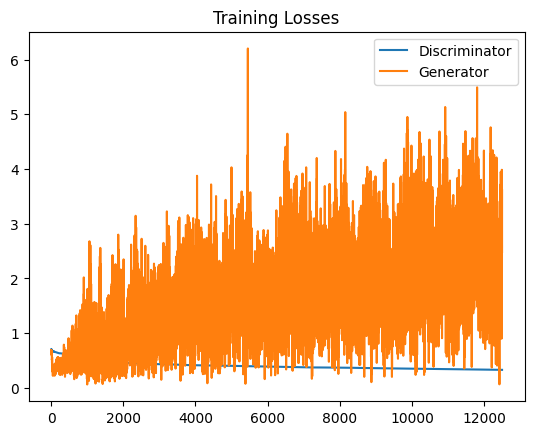

In [37]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

The loss convergence towards the end signifies that the GAN model has reached optimality

### 2.7 Anomaly Detection

What was the result of all the training we did?  

We now have a generator that can input a random seed value and produce an output that closely resembles the data it was trained on. You can read about how this strategy was used to come up with imaginary celebrities <a href ="https://research.nvidia.com/publication/2017-10_Progressive-Growing-of" >here</a>

The Discriminator that we trained ended up being a very powerful classifier that can tell if a sample point is representative of the true data distribution it was trained on or not and hence can be used for Anomaly Detection!

Let us feed our test data into the discriminator and obtain scores.

In [ ]:
# Predictions on the test set

nr_batches_test = np.ceil(x_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):    
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = x_test[ran_from:ran_to]             
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)        
        results = np.append(results, tmp_rslt)   

Let us calculate the mean score for normal and anomalous samples in our test set. Ideally, we would like to see a score close to 1 for normal samples and 0 for anomalous samples. This would mean our classifier is doing well in distinguishing between the 2 classes.  

In [40]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y_test)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for normal packets :', results_df.loc[results_df['y_test'] == 0, 'results'].mean() )
print ('Mean score for anomalous packets :', results_df.loc[results_df['y_test'] == 1, 'results'].mean())

Mean score for normal packets : 0.5569486018178649
Mean score for anomalous packets : 0.5867695628832548


But how exaclty do we identify our Anomalies?

Although there are several ways to do this, let us use a more straight forward way for detection. Remember 1% of our test set comprised of anomalies. So, the lowest 1% of the scores should ideally constitute anomalies. Let us test our hypothesis below.

In [41]:
#Obtaining the lowest 1% score
per = np.percentile(results,1)
y_pred = results.copy()
y_pred = np.array(y_pred)

#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1


## Section 3: Evaluation

The Accuracy, Precision and Recall values of our model on the test set are as follows:

In [42]:
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(y_test, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.6
Precision : 0.0
Recall : 0.0
F1 : 0.0


### 3.1 Confusion Matrix

The confusion matrix is a good way to understand if our predictions agree with the target labels. You've implemented one of these in both of the previous labs, so in this section, you'll get a chance to build your own. 

Confusion Matrix :


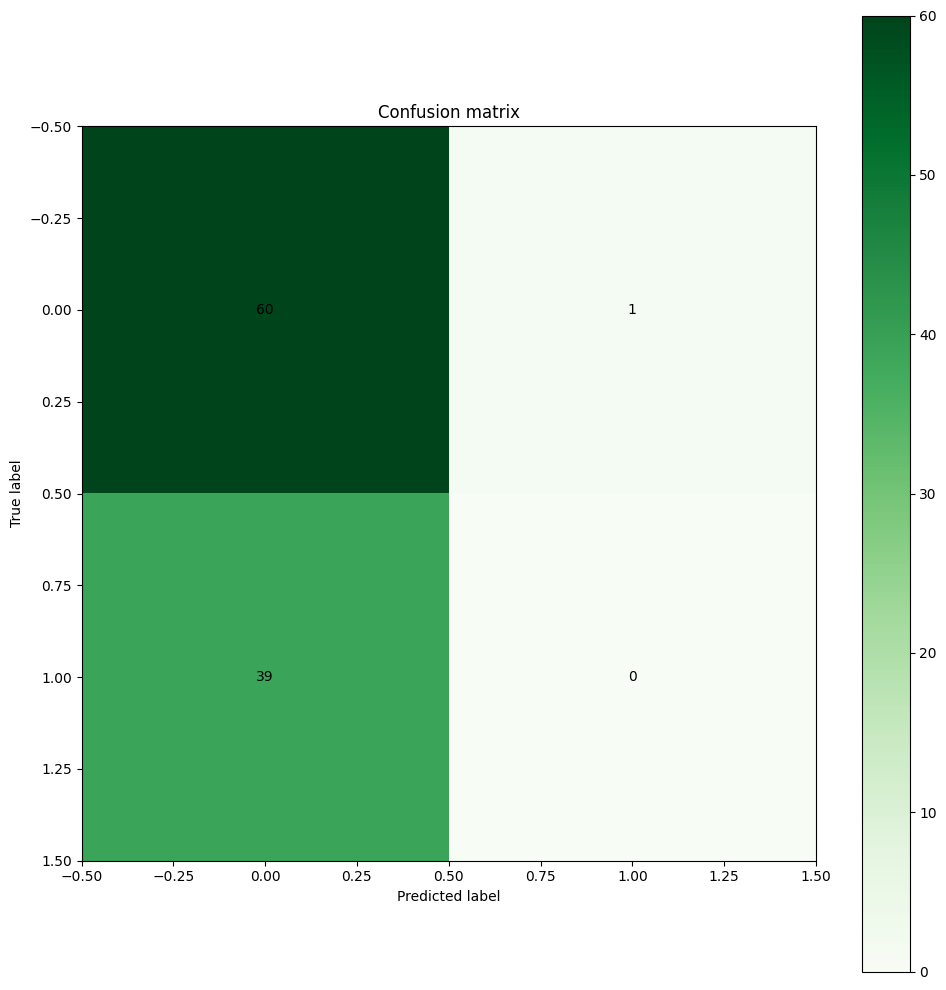

In [43]:
cm = confusion_matrix(y_test, y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

### 3.2 ROC Curve

Let's see how our ROC curve looks with the predictions. The closer the AUC is to 1, the better the model.

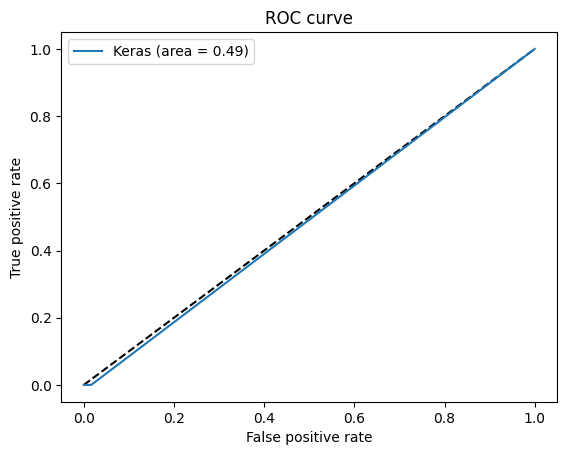

In [44]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Conclusion

- We successfully employed state of the art Generative Adversarial Networks for anomaly detection on high dimensional data such as the KDD dataset.
- The GAN is particularly interesting  because it sets up a supervised learning problem in order to do unsupervised learning. While it generates fake data, and tries to determine if a sample is fake or real based on trivial labels, it really does not know what the different classes in the dataset are.
- On the downside, GANs can be tough to train and suffer from convergence issues particularly because, the discriminator during training does not learn as much from the true dataset as it learns to distinguish between the probability distributions.

Take a moment to consider how each of the three methods actually detected anomalies. If time, take a moment to attempt to articulate each to a partner or write in a notebook or the space below. Bonus. Reflect on how each responded to the rarity of anomalies and why.

## References

<ol>
<li>Zenati, H., Foo, C., Lecouat, B., Manek, G. and Chandrasekhar, V. (2018). Efficient GAN-Based Anomaly Detection. [online]   Arxiv.org. Available at: https://arxiv.org/abs/1802.06222</li>

<li>Ben Poole Alex Lamb Martin Arjovsky Olivier Mastropietro Vincent Dumoulin, Ishmael Belghazi and Aaron Courville. Adversarially learned inference. International Conference on Learning Representations, 2017.</li>

<li>Antonia Creswell, Tom White, Vincent Dumoulin, Kai Arulkumaran, Biswa Sengupta, and Anil A.Bharath. Generative adversarial networks: An overview. In the Proceedings of IEEE Signal Processing Magazine Special Issue on Deep Learning for Visual Understanding, accepted paper,2017.</li>

<li>Martin Renqiang Min Wei Cheng Cristian Lumezanu Daeki Cho Haifeng Chen Bo Zong, Qi Song.Deep autoencoding gaussian mixture model for unsupervised anomaly detection. International Conference on Learning Representations, 2018.</li>

<li>Shuangfei Zhai, Yu Cheng, Weining Lu, and Zhongfei Zhang. Deep structured energy based models for anomaly detection. International Conference on Machine Learning, pp. 1100-1109, 2016.</li>
</ol>

